Eivind: LSTM, XGB // NN, LR

In [17]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf  # module to run ordinary least squares analysis
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score  # Import regression metrics


In [57]:
# Load and prepare the data
df = pd.read_csv("../data/Tuddal_data.csv", na_values=np.nan)

df["albedo"] = df['R_SW_in'] / df['R_LW_out_corr']

# Define features and target variable
features = ["wind_speed", "max_wind_speed", "R_SW_in", "precip_int_h_D", "albedo",
        "air_temperature", "wind_dir", "specific_humidity",
        "air_pressure", "precip_int_h_D", 
        "FC1DRIFTsum_99_99_1_1_1", "FC2DRIFTsum_99_99_1_1_1"]

df_cont = df.dropna(subset=['LE_qc0']) 
df_cont = df.dropna(subset=features) 

y = df_cont["LE_qc0"] # filtered data
X = df_cont[features] # filtered data
t = df_cont['timestamp'] #filtered data
y2 = df["LE_qc0"] # non-filtered data
t2 = df['timestamp'] # non-filtered data

Text(0, 0.5, 'Latent heat')

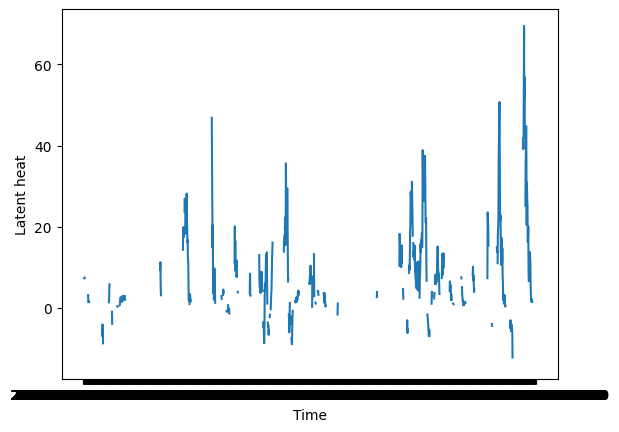

In [51]:
# Plots the non-filtered data to get an overview
plt.plot(t2,y2)
plt.xlabel('Time')
plt.ylabel('Latent heat')

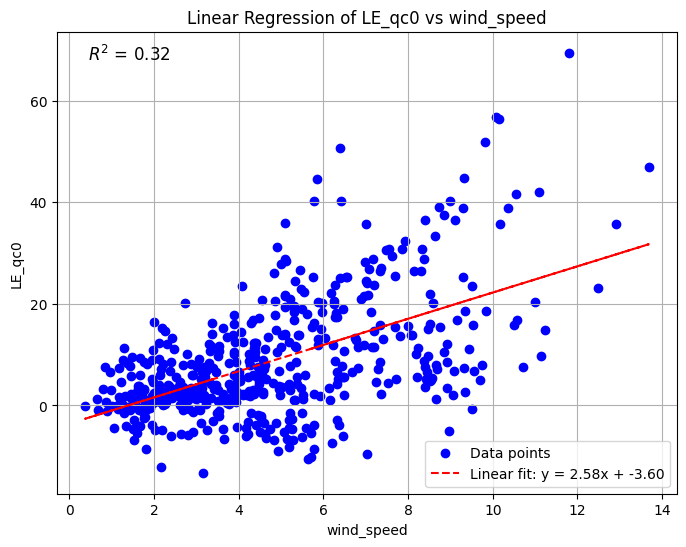

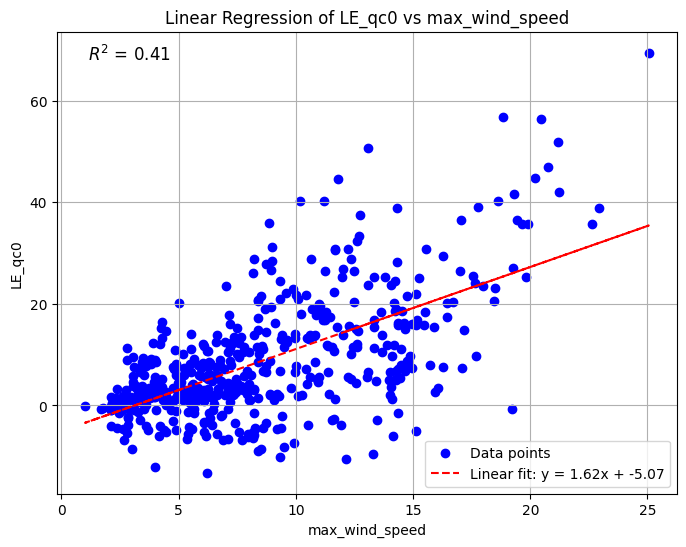

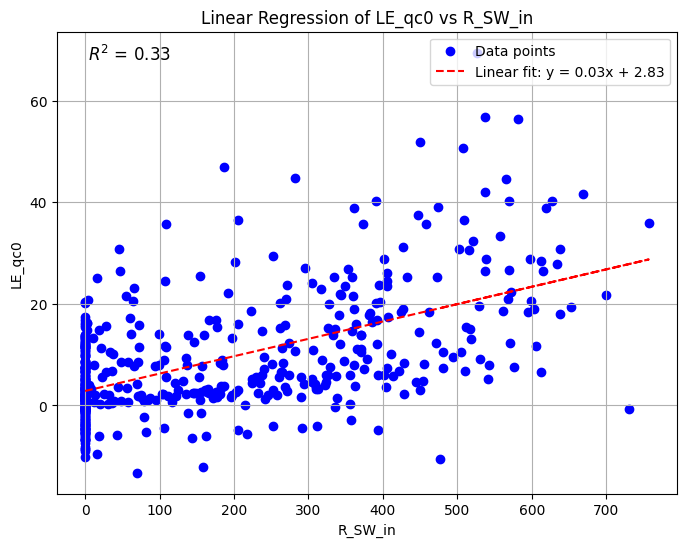

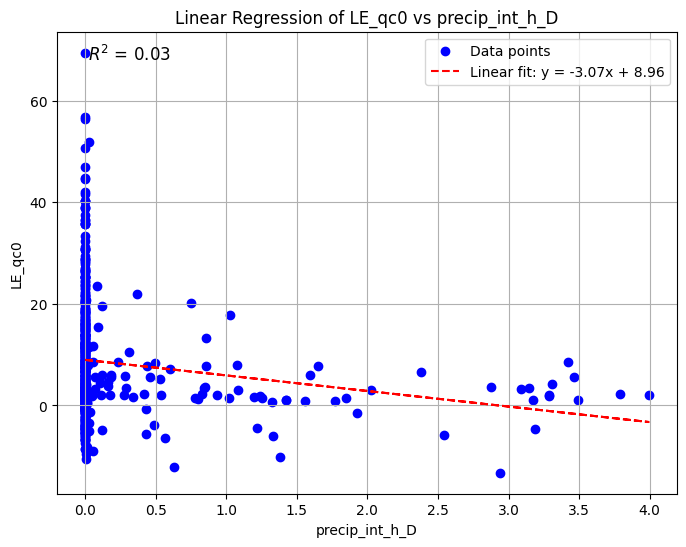

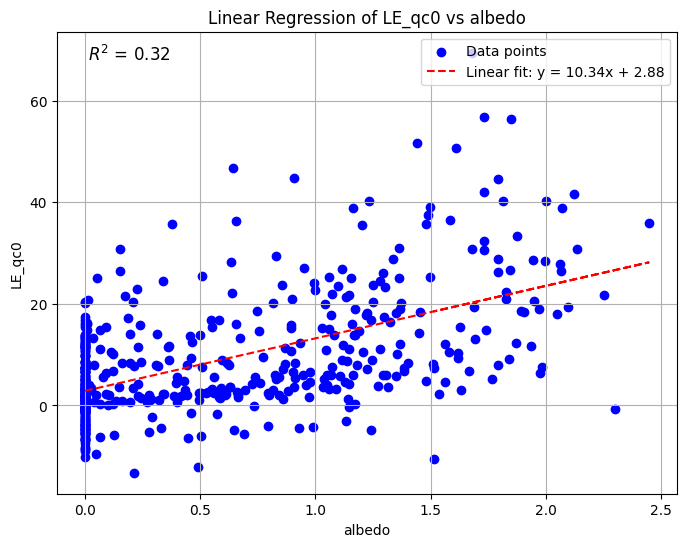

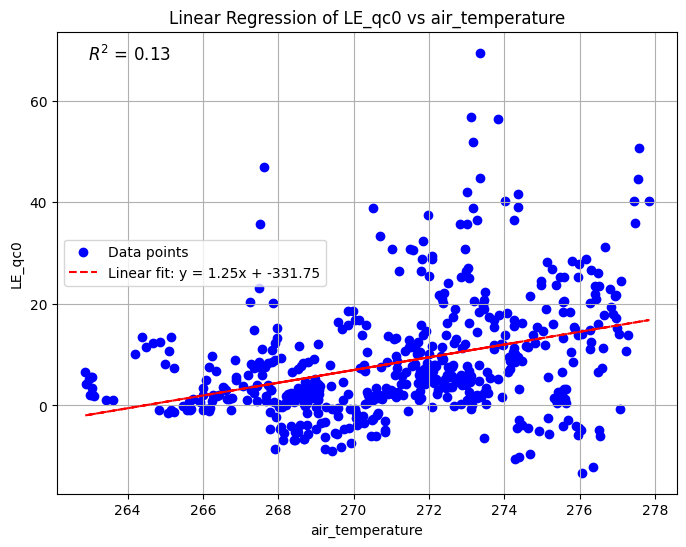

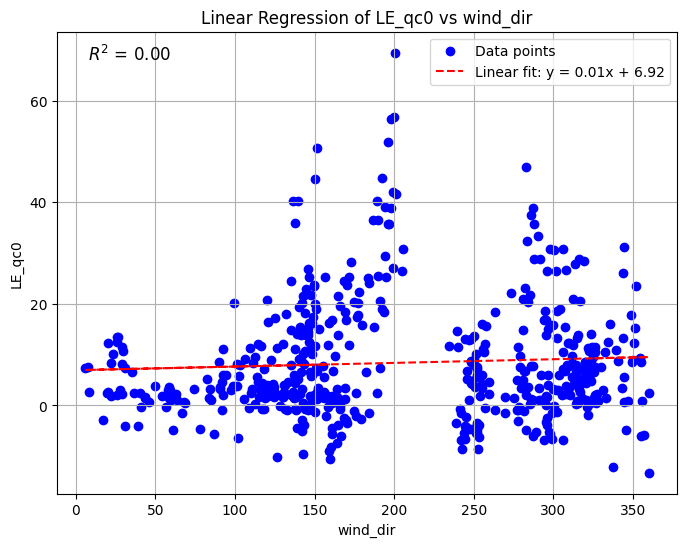

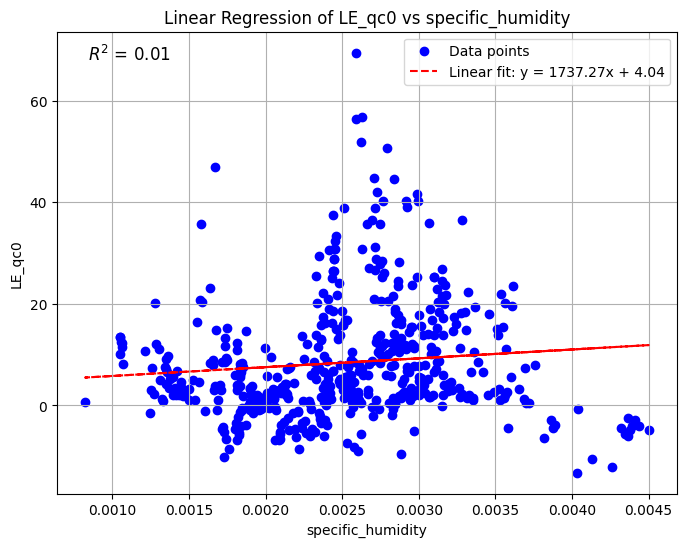

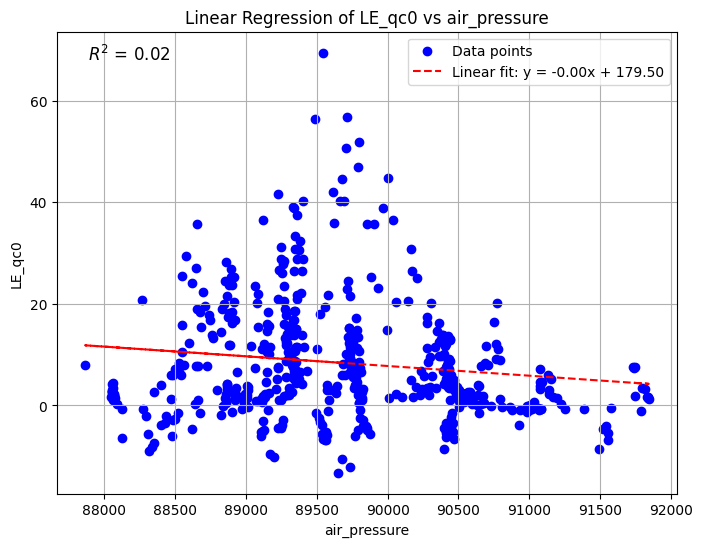

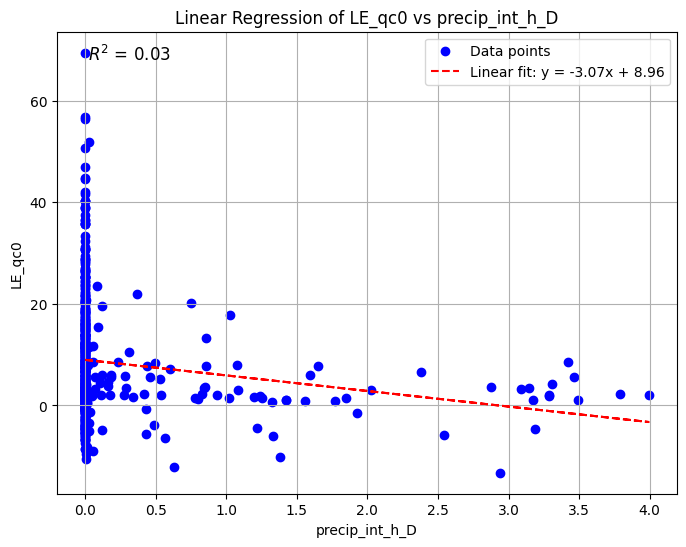

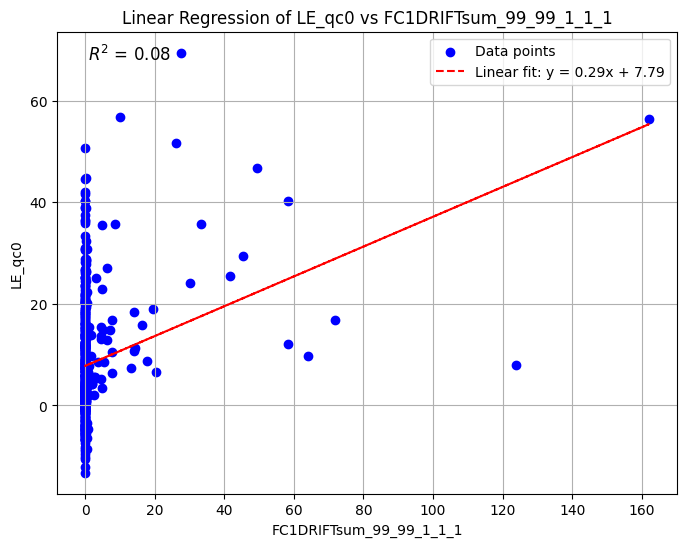

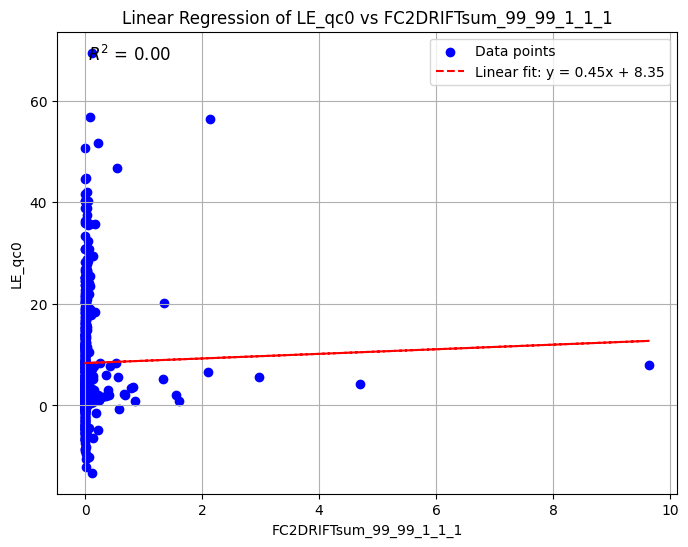

In [35]:
# Initialize empty lists for intercept, slope, and R-squared values
intercept = []
slope = []
r_squared = []

# Loop over the indices and elements of 'features' to ensure integer index access
for i, param in enumerate(features):
    # Perform linear regression on the specified parameter
    linfit = smf.ols(formula=f'LE_qc0 ~ {param}', data=df_cont[[param, 'LE_qc0']]).fit()
    intercept_input, slope_input = linfit.params
    r2_value = linfit.rsquared
    
    # Append the intercept, slope, and R-squared values to their respective lists
    intercept.append(intercept_input)
    slope.append(slope_input)
    r_squared.append(r2_value)
    
    # Plot the data and regression line
    plt.figure(figsize=(8, 6))
    plt.scatter(df_cont[param], df_cont['LE_qc0'], color='blue', label='Data points')
    
    # Create the regression line using the slope and intercept
    x_vals = np.array(df_cont[param])
    y_vals = intercept_input + slope_input * x_vals
    plt.plot(x_vals, y_vals, color='red', label=f'Linear fit: y = {slope_input:.2f}x + {intercept_input:.2f}',ls='--')
    
    # Add the R-squared value to the plot
    plt.text(0.05, 0.95, f'$R^2$ = {r2_value:.2f}', ha='left', va='center', transform=plt.gca().transAxes, fontsize=12, color='black')
    
    # Set plot labels and title
    plt.xlabel(param)
    plt.ylabel('LE_qc0')
    plt.title(f'Linear Regression of LE_qc0 vs {param}')
    plt.legend()
    plt.grid(True)
    plt.show()



Text(0.5, 0, 'Y')

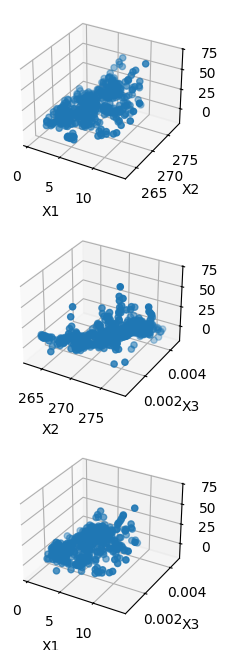

In [18]:
# Plotting the data in 3D space

x1=df['wind_speed']
x2=df['air_temperature']
x3=df['specific_humidity']

fig = plt.figure(figsize=(4,8))
ax1 = fig.add_subplot(311, projection='3d')
ax2 = fig.add_subplot(312, projection='3d')
ax3 = fig.add_subplot(313, projection='3d')

ax1.scatter(x1, x2, y)
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_zlabel("Y")
#ax1.set_box_aspect(aspect=None, zoom=0.8)

ax2.scatter(x2, x3, y)
ax2.set_xlabel('X2')
ax2.set_ylabel('X3')
ax2.set_zlabel("Y")
#ax2.set_box_aspect(aspect=None, zoom=0.8)

ax3.scatter(x1, x3, y)
ax3.set_xlabel('X1')
ax3.set_ylabel('X3')
ax3.set_zlabel("Y")
#ax3.set_box_aspect(aspect=None, zoom=0.8)

In [61]:
# Generating synthetic data
# Latent heat and the three variables with the highest R-squared when compared with latent heat in linear regression: 
# maximum wind speed (mws), incoming shortwave radiaton (sw_in) and albedo (alb)

# Current state: no covariance implemented between the data 

# Define column statistics based on the original dataset
num_rows = len(df)  # Choose the number of rows for the synthetic dataset
mean_value_le = np.mean(y) # mean of the latent heat data
std_dev_le = np.std(y) # std deviation of the latent heat data

mean_value_mws = np.mean(df_cont['max_wind_speed']) # mean of the max wind speed data
std_dev_mws = np.std(df_cont['max_wind_speed']) # std deviation of the max wind speed data

mean_value_sw_in = np.mean(df_cont['R_SW_in']) # mean of the shortwave in data
std_dev_sw_in = np.std(df_cont['R_SW_in']) # std deviation of the shortwave in data

mean_value_alb = np.mean(df_cont['albedo']) # mean of the albedo data
std_dev_alb = np.std(df_cont['albedo']) # std deviation of the albedo data

# Generate synthetic data
synthetic_le = np.random.normal(mean_value_le, std_dev_le, num_rows)
synthetic_mws = np.random.normal(mean_value_mws, std_dev_mws, num_rows)
synthetic_sw_in = np.random.normal(mean_value_sw_in, std_dev_sw_in, num_rows)
synthetic_alb = np.random.normal(mean_value_alb, std_dev_alb, num_rows)

# Define means and covariance matrix
#mean = [50, 30]
#cov = [[1, 0.8], [0.8, 1]]  # High correlation between two variables
#synthetic_correlated_data = np.random.multivariate_normal(mean, cov, num_rows)

# Separate the columns
#synthetic_column_1, synthetic_column_2 = synthetic_correlated_data[:, 0], synthetic_correlated_data[:, 1]

# Combining columns into a dataframe
synthetic_df = pd.DataFrame({
    'LE_synthetic': synthetic_le,
    'mws_synthetic': synthetic_mws,
    'sw_in_synthetic': synthetic_sw_in,
    'albedo_synthetic': synthetic_alb,
})


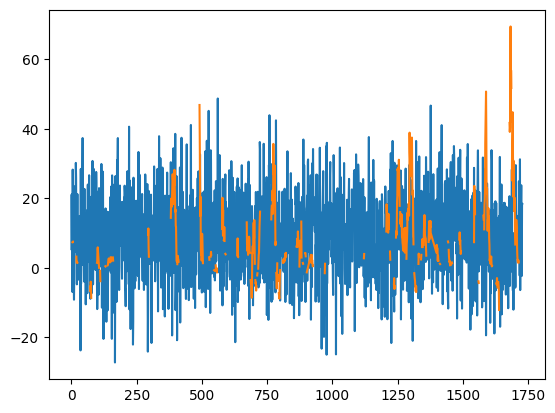

In [60]:
plt.plot(synthetic_le)
plt.plot(y)